In [79]:
from glob import glob
import os
from collections import namedtuple

# numerical tools
import numpy as np
import scipy.stats
import pandas as pd

# plotting tools
from matplotlib import pyplot as plt

# interactive notebook features
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact

# meg analysis
import mne

## Find all available subjects

Define where you store your `camcan` data in the variable `camcanroot`.

In [76]:
camcanroot = '/Volumes/Seagate Expansion Drive/camcan'
megdataroot = os.path.join(camcanroot, 'cc700/mri/pipeline/release004/BIDSsep/megraw/')
subjects = glob(os.path.join(megdataroot, 'sub-*'))
ids = [os.path.split(subject)[-1][4:] for subject in subjects]

print(f'{len(subjects)} subjects found in {megdataroot}')

647 subjects found in /Volumes/Seagate Expansion Drive/camcan/cc700/mri/pipeline/release004/BIDSsep/megraw/


## Find the demographic information

Read the demographic information from the .tsv file provided.

In [127]:
subject_details = pd.DataFrame.from_csv(os.path.join(camcanroot, 'cc700-scored/participant_data.csv'))

## Loop over MEG data



In [128]:
sub_params = namedtuple('sub_params',
                        ['pid', 'slopes', 'age', 'gender',
                         'intercepts', 'rsquared'])

all_parameters = []
psds = []

for subject in tqdm(range(20)):
    # resting state file
    restfile = os.path.join(subjects[subject], 'meg/rest_raw.fif')
    # raw data
    raw = mne.io.read_raw_fif(restfile, verbose='WARNING')
    # pick gradiometers
    picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, eog=False, exclude='bads')
    # do the PSD analysis
    psd, freqs = mne.time_frequency.psd_welch(
        raw, picks=picks, fmin=2, fmax=24, tmin=1, tmax=601, n_fft=2000, n_overlap=1000,
        verbose='WARNING'
    )
    # Do the linear regression
    findices = (freqs < 7) | (freqs > 14)
    linfits = [scipy.stats.linregress(freqs[freqband], np.log10(psd.T[freqband, grad]))
               for grad in range(psd.shape[0])]

    psds.append(psd)
    all_parameters.append(
        sub_params(pid=ids[subject],
                   slopes=[l.slope for l in linfits],
                   intercepts=[l.intercept for l in linfits],
                   rsquared=[l.rvalue**2 for l in linfits],
                   age=subject_details.loc[ids[subject]].age,
                   gender=subject_details.loc[ids[subject]].gender_code)
    )


### Average power-spectrum

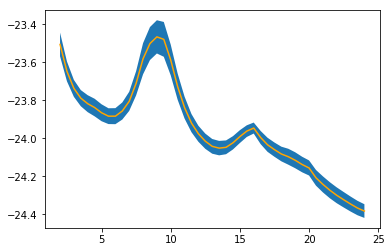

In [129]:
pltdata = np.log10(np.stack([p.mean(axis=0) for p in psds], axis=-1))

plt.figure()
plt.fill_between(freqs,
                 np.mean(pltdata, axis=-1)-scipy.stats.sem(pltdata, axis=-1),
                 np.mean(pltdata, axis=-1)+scipy.stats.sem(pltdata, axis=-1))
plt.plot(freqs, np.mean(pltdata, axis=-1), color='orange')
plt.show()

### Boxplot of regression slope across electrodes for each subject

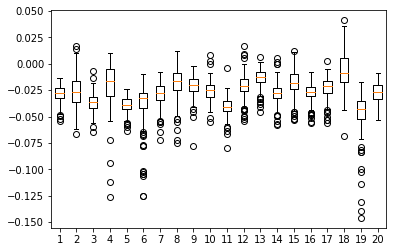

In [130]:
y = np.array([p.slopes for p in all_parameters])

plt.figure()
plt.boxplot(y.T)
plt.show()


### Scatter plot of age vs 1/f noise

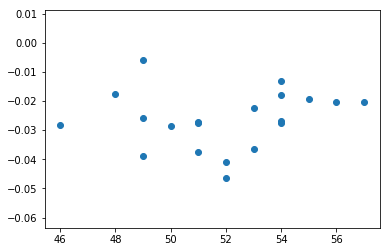

In [132]:
x = [p.age for p in all_parameters]
y = [np.mean(p.slopes) for p in all_parameters]

plt.figure()
plt.scatter(x, y)
plt.show()